<img src="https://www.aiforpeople.org/wp-content/uploads/2020/01/cropped-AIforPeople-logo-full-2.png" width="200">

# Introduction to Topic Modeling

In this notebook we will analyse a fictional corpus of tweets. This corpus has been generated using the [GPT-2 language model](https://openai.com/blog/better-language-models/), fine-tuned on a corpus of tweets gathered for a [research project](https://arxiv.org/abs/2004.06986). The initial corpus has been gathered to analyse the language use during the Covid-19 pandemic in Twitter in the first weeks:


---



<img src="https://i.imgur.com/RmK5iPr.png" width="750" href="https://arxiv.org/abs/2004.06986">


---

Our analysis will start with a few basics. How do we load the dataset, how do we store the data and what are some key statistics that we can load from it. Afterwards, we will have a look at **topic modeling** and **sentiment analysis**.

Let's start by acquiring the dataset that we have created in the last session. It has been stored in the public [Github of AI for People](https://github.com/aiforpeople-git). We load the dataset address through the raw file url:

---
<img src="https://i.imgur.com/0EbFrtz.png" width="750" href="https://arxiv.org/abs/2004.06986">

---

Afterwards, we can use the native python library *urllib* to send a request to the url and retrieve the dataset. This data is stored in our `data` variable. Let's have a look at the first 10 entries. The data is currently stored as `HTTPResponse` object. Therefore, we decode each line as text using `.decode('utf-8')`.




In [1]:
import urllib

dataset_address = "https://raw.githubusercontent.com/aiforpeople-git/First-AI4People-Workshop/master/NLP_AI/gpt2_corona_tweets.txt"

data = urllib.request.urlopen(dataset_address)

for idx, line in enumerate(data):
  decoded_line = line.decode("utf-8")
  print(decoded_line)
  if idx == 10:
    break

1/03/2020	:::	@Dixit_Munjani @srinivas_inlvd The way economic situation is situation of our state is a hindrance for our schemes and policies but we can utilize every material available to create activities.

1/03/2020	:::	These people are ignorant

1/03/2020	:::	@BaiSuthu @dharipSureshg @acna_ghatkan10 @NamitaKVj No good(ish) will come out of this Corona going on

1/03/2020	:::	@kyledwinne Maybe this is why covid-19 is so hard to track down

1/03/2020	:::	@BuzzMorrisTrump Good the 3 highest getting covid 19 countries where about them corona cases.  and big country like US and UK

1/03/2020	:::	Poor @SusanFlu @TimeWarBruh @berniesanders @LindseyGrahamSC Did you think #COVID19 was a hoax? So disrespectful... Fair warning @senatemajldr https://t.co/pnSc4f2jjL2

1/03/2020	:::	Shameful. https://t.co/GyD3w1wgyZ

1/03/2020	:::	#COVID19 is the answer

1/03/2020	:::	as if U asked u before checking ur covid cases😂 https://t.co/A7TgfAecAx

1/03/2020	:::	Exactly no right man’s ... https://t.co/hq

## Data Preprocessing

Currently, we have simply taken all of the tweets that the language model has generated. But the same as any data, there is a lot of **noise** in the dataset. So, therefore we can do some simple preprocessing. Let us define what tweets we do **not** want to investigate:

*   Tweets with less than three characters ("aa", "bo", "#&")
*   Tweets that only consist of mentions (@bla, @blo, @blib)
*   Tweets with more than 240 characters

Technically, these tweets should not exists, but since we have used a language model, they might. In any case, filtering your dataset for bot-responses, spam responses etc. is useful in any case. GPT-2 uses the tokens `<|endoftext|>` and `<|startoftext|>` in its learning and those might end up in the generated data.

Also, we should identify how we want to store the data. Currently, everything is stored in one big list with each line being a tweet with date. Let us store the data in a dictionary with the date as a token and the tweet as a value, while we are filtering for the above requirements:



In [2]:
# Creating the dictionary for our data
dataset = dict()

# Iterating over the read dataset
for idx, line in enumerate(data):
  decoded_line = line.decode("utf-8")
  content = decoded_line.split("\t:::\t")

  # Extracting the tweet and date from each line
  date = content[0]
  tweet = content[1].strip()

  # Processing each tweet
  if len(tweet) < 3: 
    continue # tweet with less then 3 characters
  if all([element.startswith("@") for element in tweet.split(" ")]):
    continue  # tweet only consists of @-mentions
  if len(tweet) > 240: 
    continue # tweet with more than 240 characters
    
  # Storing each tweet with its corresponding date
  if date not in dataset.keys():
    dataset[date] = []
    dataset[date].append(tweet)
  else:
    dataset[date].append(tweet)
    


We have now preprocessed our data and it should be clear how you can apply your own filters. Next up, we can look at how the data has been stored by printing the date and the number of corresponding tweets gathered for each day:

In [3]:
for key, value in dataset.items():
  print(key,":", len(value), "tweets")

1/03/2020 : 892 tweets
2/03/2020 : 877 tweets
3/03/2020 : 905 tweets
4/03/2020 : 904 tweets
5/03/2020 : 900 tweets
6/03/2020 : 871 tweets
7/03/2020 : 877 tweets
8/03/2020 : 894 tweets
9/03/2020 : 872 tweets
10/03/2020 : 905 tweets
11/03/2020 : 894 tweets
12/03/2020 : 883 tweets
13/03/2020 : 887 tweets
14/03/2020 : 884 tweets
15/03/2020 : 877 tweets
16/03/2020 : 891 tweets
17/03/2020 : 898 tweets
18/03/2020 : 873 tweets
19/03/2020 : 879 tweets
20/03/2020 : 865 tweets
21/03/2020 : 906 tweets
22/03/2020 : 881 tweets
23/03/2020 : 888 tweets
24/03/2020 : 895 tweets
25/03/2020 : 906 tweets
26/03/2020 : 891 tweets
27/03/2020 : 885 tweets
28/03/2020 : 878 tweets
29/03/2020 : 891 tweets


## Some Basic Statistics
In order to get a sense of the data we are dealing with, we shall now look at some random topic we suspect to occur in the data. In the next part of this course, we will actually use topic modeling to confirm the occurrence of such topic. Since we are dealing with temporal data of about the coronavirus discourse, we could expect that one of the key figures in American politics with the most credible background should appear in our dataset:

<img src="https://media0.giphy.com/media/WUHdrlI5kLkHUrRDOr/source.gif" width="400">

Let us investigate how often the term "fauci" is present in the dataset and maybe we can observe some effects over time. **Disclaimer**: We are dealing with a fictional dataset that does not reflect the actual discourse but rather mirrors patterns of it.


In [4]:
fauci_counts = dict()
for date, tweets in dataset.items():
  date = date.replace("/2020", "")
  fauci_counts[date] = 0

  for tweet in tweets:
    if "fauci" in tweet.lower() or "dr.fauci" in tweet.lower():
      fauci_counts[date]+=1

print(fauci_counts)

{'1/03': 3, '2/03': 1, '3/03': 1, '4/03': 3, '5/03': 3, '6/03': 2, '7/03': 2, '8/03': 1, '9/03': 0, '10/03': 1, '11/03': 2, '12/03': 1, '13/03': 1, '14/03': 0, '15/03': 1, '16/03': 0, '17/03': 0, '18/03': 1, '19/03': 0, '20/03': 0, '21/03': 0, '22/03': 1, '23/03': 0, '24/03': 1, '25/03': 0, '26/03': 1, '27/03': 1, '28/03': 2, '29/03': 2}


We have now collected the number of tweets that mention Fauci on every day of our corpus. Next, we could think of visualizing these mentions over time. The next cell uses a few cosmetical tricks and tweaks to create an illustrative plot, but nothing that would be necessary to understand the data, so don't panic if you do not understand every line of code.

Text(0, 0.5, "Tweets with Fauci's name")

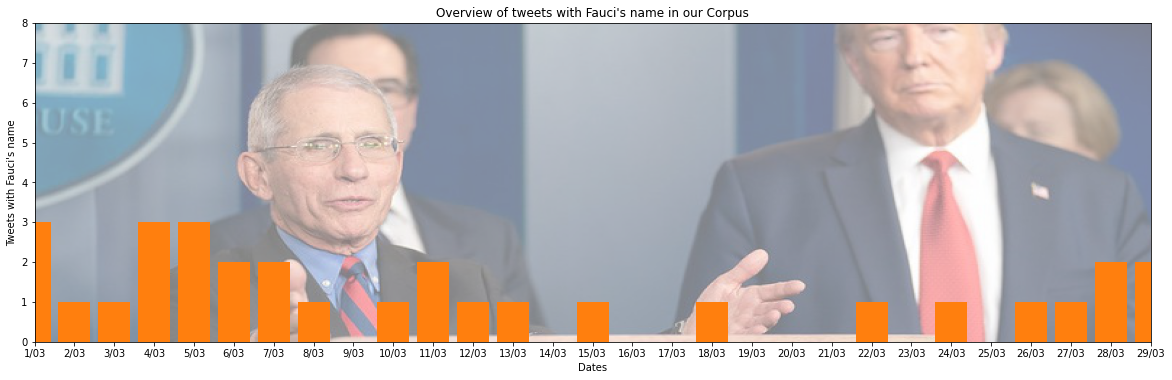

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=[20,20]);
plt.bar(list(fauci_counts.keys()), list(fauci_counts.values()), color="C1");

img = urllib.request.urlopen("https://i.imgur.com/nVMEjpC.jpg");
img = plt.imread(img, format='jpg');
plt.imshow(img, zorder=0, extent=[0, 29.0, 0, 10.0], alpha=0.5)
plt.xlim([list(fauci_counts.keys())[0], list(fauci_counts.keys())[-1]])
plt.ylim([min(fauci_counts.values()), int(max(fauci_counts.values()))+5])
plt.title("Overview of tweets with Fauci's name in our Corpus")
plt.xlabel("Dates")
plt.ylabel("Tweets with Fauci's name")


We can do the same kind of word occurrence with different keywords. For example, we can check how often the President of the US has been talked about in comparison to Fauci. For this, we can take the same code and store results from a different search term in a different variable and have a comparative plot.

{'1/03': 45, '2/03': 55, '3/03': 68, '4/03': 53, '5/03': 55, '6/03': 43, '7/03': 60, '8/03': 55, '9/03': 57, '10/03': 68, '11/03': 61, '12/03': 60, '13/03': 50, '14/03': 62, '15/03': 54, '16/03': 59, '17/03': 51, '18/03': 58, '19/03': 62, '20/03': 45, '21/03': 57, '22/03': 38, '23/03': 47, '24/03': 54, '25/03': 59, '26/03': 50, '27/03': 58, '28/03': 51, '29/03': 48}


Text(0, 0.5, 'Tweets with name')

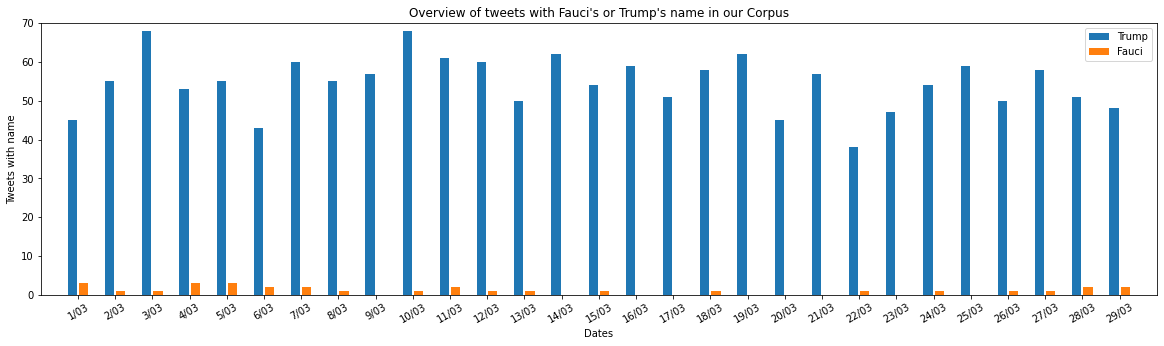

In [6]:
trump_counts = dict()
for date, tweets in dataset.items():
  date = date.replace("/2020", "")
  trump_counts[date] = 0

  for tweet in tweets:
    if "trump" in tweet.lower():
      trump_counts[date]+=1

print(trump_counts)

x_names = list(fauci_counts.keys())
x_range = list(range(0, len(fauci_counts.keys())))

plt.figure(figsize=[20,5])
plt.bar([val-.15 for val in x_range], list(trump_counts.values()), color="C0", label="Trump", width=0.25)
plt.bar([val+.15 for val in x_range], list(fauci_counts.values()), color="C1", label="Fauci", width=0.25)


plt.xlim([-1, len(fauci_counts.keys())])
plt.ylim([0,70])
plt.legend()
plt.xticks(range(0, len(fauci_counts.keys())), x_names, rotation=30)
plt.title("Overview of tweets with Fauci's or Trump's name in our Corpus")
plt.xlabel("Dates")
plt.ylabel("Tweets with name")



---




# Topic Modeling - Latent Dirichlet Allocation (LDA)

In this section we are going to use a topic modeling strategy called **Latent Dirichlet Allocation**. If you want to understand LDA properly we can recommend the following links:

- [Youtube Explainer](https://youtu.be/3mHy4OSyRf0)

<img src="https://i.imgur.com/RrDPbAk.jpg" height="150">

- [Intuitive Guide to Latent Dirichlet Allocation](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

<img src="https://i.imgur.com/k5h25nb.jpg" height="150">

This topic modeling will be the standard LDA approach using the Gensim library. Although, there are many other packages available (NLTK, Scikit etc.) we have chosen Gensim here and we provide a bit of an intuition when it comes to a more fine-grained setting of the LDA.

## Statistical Inference (Variational Bayes vs. Gibbs Sampling)
Learning the various distributions in our corpus (the set of topics, their associated word probabilities, the topic of each word) is a problem of statistical inference. There are different ways of doing this statistical inference. The original [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) uses a variational Bayes approximation of the posterior distribution. What is variational Bayes then? As far as we are concerned [variational Bayesian methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) are a family of techniques for approximating intractable integrals arising during the training of our LDA model. A different method of doing the statistical inference is [Gibbs Sampling](https://en.wikipedia.org/wiki/Gibbs_sampling). It [has been argued that Gibbs Sampling is more suitable](http://www.jmlr.org/papers/volume18/16-374/16-374.pdf) for the task of LDA.

Make sure that whatever LDA package you are using, to check what kind of statistical inference is used within its training. For Gensim, we can check the documentation: https://radimrehurek.com/gensim/models/ldamodel.html and realize "The core estimation code is based on the onlineldavb.py script, by Hoffman, Blei, Bach: Online Learning for Latent Dirichlet Allocation, NIPS 2010.", which is using Online Variational Bayes. In order to use Gibbs Sampling instead, we can use the Mallet package that provides a method called LdaMallet - which is using our Gibbs Sampling: https://radimrehurek.com/gensim/models/wrappers/ldamallet.html as it states "This module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents, using an (optimized version of) collapsed gibbs sampling from MALLET."

**Note**: You can use whatever LDA inference method you want. This tutorial will use Gibbs Sampling. But you can also simply use the standard Variational Bayes or a different NLP library altogether.

## Setting up the Gensim Environment
This notebook is created using Python 3.6 with a few libraries. Mainly, we are using the Gensim library (pip install Gensim), the Mallet wrapper (for the Gibbs Sampling) and a few others. Therefore, the next cells contains all the necessary libraries so you can make sure everything is installed on your system. [See how to install mallet for your local machine here.](https://www.tutorialspoint.com/gensim/gensim_creating_lda_mallet_model.htm)

**Note**: If you just want to use the standard gensim LDA, you can simply do so with `lda = LdaModel(your_corpus, num_topics=10)`. Since we are changing this function with a wrapper, we need the next lines of code to get everything into place. You do not need to *understand* exactly what's happening for this setup (Credit to [Geoff Ford](https://github.com/polsci/colab-gensim-mallet), who explained really well how to use Mallet on Colab).

In [7]:
!pip install --upgrade gensim

import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version   
install_java()

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip


     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
--2020-08-05 10:04:06--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  15.0MB/s    in 1.0s    

2020-08-05 10:04:08 (15.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8

Now, after we've installed the Mallet wrapper, we can just import all the necessary libraries for our LDA analysis and point the system towards the installed Mallet archive.

In [8]:
# importing all libraries
import os
import gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from wordcloud import WordCloud
from IPython.display import HTML
from nltk.tokenize import TweetTokenizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

Now, everything is set and we can start the topic modeling. Usually, topic modeling is performed on a set of documents each of which contains of text. In our case, we do not have multiple documents but multiple tweets that we want to treat as documents in order to identify topics of those tweets. The very first step is therefore to iterate over our data and transform the stored tweets in to a list of documents.

In [9]:
documents = [tweet for tweets in dataset.values() for tweet in tweets]
print("Number of documents in corpus:", len(documents))
print("One document looks like:", documents[15])

Number of documents in corpus: 25749
One document looks like: @DVKSVinod @BrijDhalla Can you for the record say that KK has broken any safety rules of covid 19 ? What is the media talk about fake deaths etc.


## Pre-Processing
Next, we will define two functions that will help us with the pre-processing of the data. For the LDA, we need to tokenize all words in our corpus. On Twitter, language has a bit of a different "slang" and hence we want our pre-processing to account for specific Twitter slang. In our first processing part, we are simply loading a list of stopwords. You can simply create a text file and store words in there, which you want to filter out. We have used some list found [here](https://github.com/meetsha/gensim/blob/master/stopwords.txt) and [here](https://gist.github.com/sebleier/554280). Now we define Gensim's simple preprocessing, which lowercases, tokenizes our words. We also don't want to allow tokens smaller than 3 items (e.g. "aa", "fu", "lo" "gg" etc).

**Note**: We already know at least one topic of the corpus: Covid-19. Therefore, if we want to explore more topics and do not want the already known topics to influence our topic modeling, we add those terms to the stopwords manually.

In [64]:
# loading the stopwords
stopwords_location = "https://raw.githubusercontent.com/aiforpeople-git/First-AI4People-Workshop/master/NLP_AI/stopwords.txt"
stopwords_data = urllib.request.urlopen(dataset_address)
stopwords =set([stopword.decode("utf-8").strip() for stopword in stopwords_data])

stopwords.update(["covid19", "coronavirus", "ncov2019", "2019nco", "ncov", "ncov2019", "2019ncov", "covid", "covid-", "covid_"])

def preprocess(word_list):
    result = []
    text = " ".join(word_list)
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stopwords:
            result.append(token)
    return result

## Tweet Tokenization
In order to work with the semantics of the tweets on a word-basis, we need to tokenize our corpus. For this, we are using the **NLTK** package now, because it contains a tokenizer that can handle tweets more appropriately. Meaning, it has more-fine grained tokenization for Twitter slang. Find out more in the [documentation of its source code](https://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer).

In [11]:
# Tokenization 
print("Tweet tokenization...")
tweet_tokenizer = TweetTokenizer()
tweet_token_docs = []
for idx, document in enumerate(documents):
    tweet_token_docs.append(tweet_tokenizer.tokenize(document))
print("... finished.")

Tweet tokenization...
... finished.


In [12]:
print("Let's look at the tokenized document: ")
print(tweet_token_docs[15])

Let's look at the tokenized document: 
['@DVKSVinod', '@BrijDhalla', 'Can', 'you', 'for', 'the', 'record', 'say', 'that', 'KK', 'has', 'broken', 'any', 'safety', 'rules', 'of', 'covid', '19', '?', 'What', 'is', 'the', 'media', 'talk', 'about', 'fake', 'deaths', 'etc', '.']


## Creating a Bag-of-Words and Dictionary
We now have to transform our tokens into bag of words in order to use the Gensim LDA. In Gensim, the corpus contains the word id and its frequency in every document. We can create a BoW corpus from a simple list of documents and from text files. What we need to do is, to pass the tokenised list of words to the object named Dictionary.doc2bow().

For a more detailed and general explanation of this, [see here](https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm).

In [13]:
print("Preprocessing...")
processed_docs = [preprocess(elem) for elem in tweet_token_docs]
dictionary = gensim.corpora.Dictionary(processed_docs)
del_ids = [k for k,v in dictionary.items() if v=='https']
dictionary.filter_tokens(bad_ids=del_ids)
dictionary.filter_extremes(no_below=2, no_above=0.1)
print("... finished.")
# turn documents in bags of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print("Let's look at the tokenized and bow-document: ")
print(bow_corpus[15])

Preprocessing...
... finished.
Let's look at the tokenized and bow-document: 
[(70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)]


## Training the LDA model (using Gibbs Sampling)
We can now train our LDA model provided the bag-of-words and dictionary we have created. Topic Modeling algorithms are trying to find topics within a given corpora. Naturally, a corpus of text does not have a pre-defined set of N topics. Therefore, we need to decide how many topics we want the LDA model to form/find within our corpus. It is a good idea to start with 1 topic and work our way up to 24 topics. In the next cell, we are running 24 trainings with an increaing topic size and store each model in `mallet_models`. Additionally, after every model is created we assess it's coherence value. [Here](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/) is an article that explains this a bit more. In very short, our coherence value is a measure of the statistical coherence within the topics. Or to put it in practical terms: the better our coherence score for a given topic size, the better. 

**Note**: there are diffenent coherence measures and we have chosen the $C_v$ measure. It is not as fast as $C_{Mass}$, but considered more thorough - if you want to learn [more about this topic, check this article](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). We store the evaluation of the $C_V$ in a list for all 24 topic sizes.

In [ ]:
break # from here on, the code is non-deterministic due to the LDA
# Therefore, we stop this cell and continue with the pre-trained models
# This way we ensure that the evaluation is in line with the presentation

In [25]:
mallet_models_coherence_cV = []
mallet_models = dict()

for num_topics in range(1, 25):
    print("Type: Mallet | Topics: "+str(num_topics))
    model_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, 
                                             num_topics=num_topics,id2word=dictionary, workers=2)
    
    coherencemodel = CoherenceModel(model=model_mallet, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_value = coherencemodel.get_coherence()
    mallet_models_coherence_cV.append(coherence_value)
    
    mallet_models[num_topics] = model_mallet

Type: Mallet | Topics: 1
Type: Mallet | Topics: 2
Type: Mallet | Topics: 3
Type: Mallet | Topics: 4
Type: Mallet | Topics: 5
Type: Mallet | Topics: 6
Type: Mallet | Topics: 7
Type: Mallet | Topics: 8
Type: Mallet | Topics: 9
Type: Mallet | Topics: 10
Type: Mallet | Topics: 11
Type: Mallet | Topics: 12
Type: Mallet | Topics: 13
Type: Mallet | Topics: 14
Type: Mallet | Topics: 15
Type: Mallet | Topics: 16
Type: Mallet | Topics: 17
Type: Mallet | Topics: 18
Type: Mallet | Topics: 19
Type: Mallet | Topics: 20
Type: Mallet | Topics: 21
Type: Mallet | Topics: 22
Type: Mallet | Topics: 23
Type: Mallet | Topics: 24


## Visualizing the Coherence
After training we can now plot the coherence for each topic size in order to identify the best topic size for further analysis. For this, we can use the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_\(clustering\)). To understand this method, we assume that our coherence value will roughly follow a saturation curve. That is, it will quickly increase with increasing topic size, but then also quickly converge towards a certain value despite ever rising topic size. That would mean, we could simply pick a very large topic number e.g. 100 topics in order to receive a high coherence value. But it simply means that our model is more confident in sorting words from the corpus in smaller topics (few topics = large topics). At the very end, if every word would get there own topic, we'd have a perfect coherence within those topics, yet we would have not gained any "topics" anymore and would end up on a word level again. Therefore, we need to find the spot at which we have an useful topic size with a reasonable coherence (the elbow in the curve).

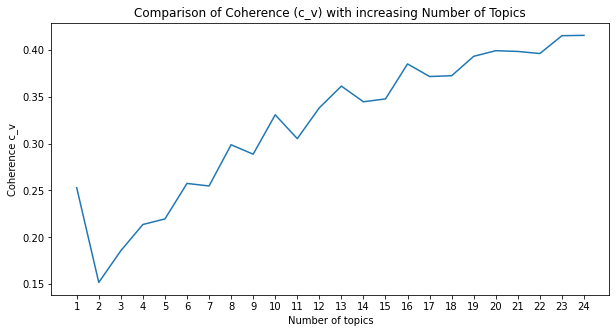

In [26]:
fig = plt.figure(figsize=[10,5])
ax = plt.axes()

ax.plot(range(1, len(mallet_models)+1),  mallet_models_coherence_cV)
plt.title("Comparison of Coherence (c_v) with increasing Number of Topics")
plt.xlabel("Number of topics")
plt.ylabel("Coherence c_v")
plt.xticks(range(1,25))
plt.show()

print()

## Storing the relevant models
If we look at the plot above we can see the first increase of coherence stop at topic size 6. We can also observe a peak at topic size 12 and a trend of slight increasing coherence up until 21 topics. We now do two technical tricks to work with those selected models further. As LDA is a statistical learning method that includes randomness in both the learning and inference steps, the resulting models that you will produce will **always** be slightly different. Your own results will be slightly different altogether. Yet, they should always show a very similar curve! 

In order to work with the exact same models and in order to save time when re-running this code at a later point, we are now firstly going to transform the mallet models into LDA models (this is just a technicality to use the standard tools for this model despite it being from a foreign package, namely mallet). We simply call the `malletmodel2ldamodel` function to do this. Secondly, we are going to store the models on our hard-drive using python's in-built archive manager pickle. With `pickle.dump` and `pickle.load` we can store and load any file.

In [36]:
# Turning mallet model to gensim model for plotting
model_6 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_models[6])
model_16 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_models[16])
model_24 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_models[24])


# Storing the relevant models
pickle.dump(model_6,open('lda_6.pkl','wb'))
pickle.dump(model_16,open('lda_16.pkl','wb'))
pickle.dump(model_24,open('lda_24.pkl','wb'))


## Loading the relevant models
You can run the notebook from here after you have trained and stored your models without having to re-run the entire training etc. You can also load the models we have provided if you have failed to create them yourself or haven't had the time to get your corpus ready. **Remember**: You always need to run the very first cell with the library imports for this loading to work.

In [37]:
# Loading the relevant models
print("Opening LDA model with 6 topics.")
with open('lda_6.pkl', 'rb') as f:
    model_6 = pickle.load(f)

print("Opening LDA model with 16 topics.")
with open('lda_16.pkl', 'rb') as f:
    model_16 = pickle.load(f)
    
print("Opening LDA model with 24 topics.")
with open('lda_24.pkl', 'rb') as f:
    model_24 = pickle.load(f)

Opening LDA model with 6 topics.
Opening LDA model with 16 topics.
Opening LDA model with 24 topics.


## First look at topics
We can now investigate our models. The first naive way to do this, is to use the `print_topics` function from the LDA model. We can specify the number of words from each topic that we'd like to investigate. In the cell below, we ask for 8 words from each topic. Each word comes with a weight/importance value for that topic. The topics are for now just labeled 0, 1, 2 and so forth. It is our task to come up with an interpretation of the provided topics, according to the words suggested for them.

In [38]:
for idx, topic in model_6.print_topics(num_words=8):
    print('Topic: {} \nWords: {}'.format(idx, topic))
print("-----------------------")
for idx, topic in model_16.print_topics(num_words=8):
    print('Topic: {} \nWords: {}'.format(idx, topic))
print("-----------------------")
for idx, topic in model_24.print_topics(num_words=8):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.040*"india" + 0.039*"time" + 0.024*"country" + 0.023*"lockdown" + 0.020*"care" + 0.017*"government" + 0.015*"china" + 0.014*"health"
Topic: 1 
Words: 0.079*"virus" + 0.022*"people" + 0.018*"shit" + 0.015*"family" + 0.014*"live" + 0.013*"feel" + 0.013*"http" + 0.013*"fuck"
Topic: 2 
Words: 0.048*"realdonaldtrump" + 0.041*"trump" + 0.013*"president" + 0.012*"house" + 0.011*"death" + 0.011*"business" + 0.011*"economy" + 0.010*"gonna"
Topic: 3 
Words: 0.033*"home" + 0.032*"work" + 0.027*"stay" + 0.020*"sick" + 0.020*"covidー" + 0.019*"great" + 0.018*"safe" + 0.016*"thing"
Topic: 4 
Words: 0.037*"world" + 0.031*"good" + 0.019*"today" + 0.019*"life" + 0.016*"state" + 0.014*"hope" + 0.013*"fight" + 0.012*"free"
Topic: 5 
Words: 0.072*"people" + 0.060*"pandemic" + 0.024*"cases" + 0.023*"stop" + 0.022*"news" + 0.012*"spread" + 0.011*"deaths" + 0.009*"dying"
-----------------------
Topic: 0 
Words: 0.064*"cases" + 0.033*"patients" + 0.029*"deaths" + 0.023*"case" + 0.022*"states

## Visualization I: Wordclouds
The results above are rather hard to interpret and we will now look at a way of visualizing those topics. One method is a very simple wordcloud. Fortunately, there is a python package for doing exactly those. In the cell below, we are generating 4 word clouds for our 4 topic model. There are a lot of parameters e.g. colors, size, orientation, dimension etc. which are all purely cosmetical and you can look at the documentation of the Wordcloud package to try and adjust/understand them. It just essential to note that the presented wordclouds are generated taking the frequency (`generate_from_frequencies`), which means that the bigger a word in the cloud, the more important it is for the topic.

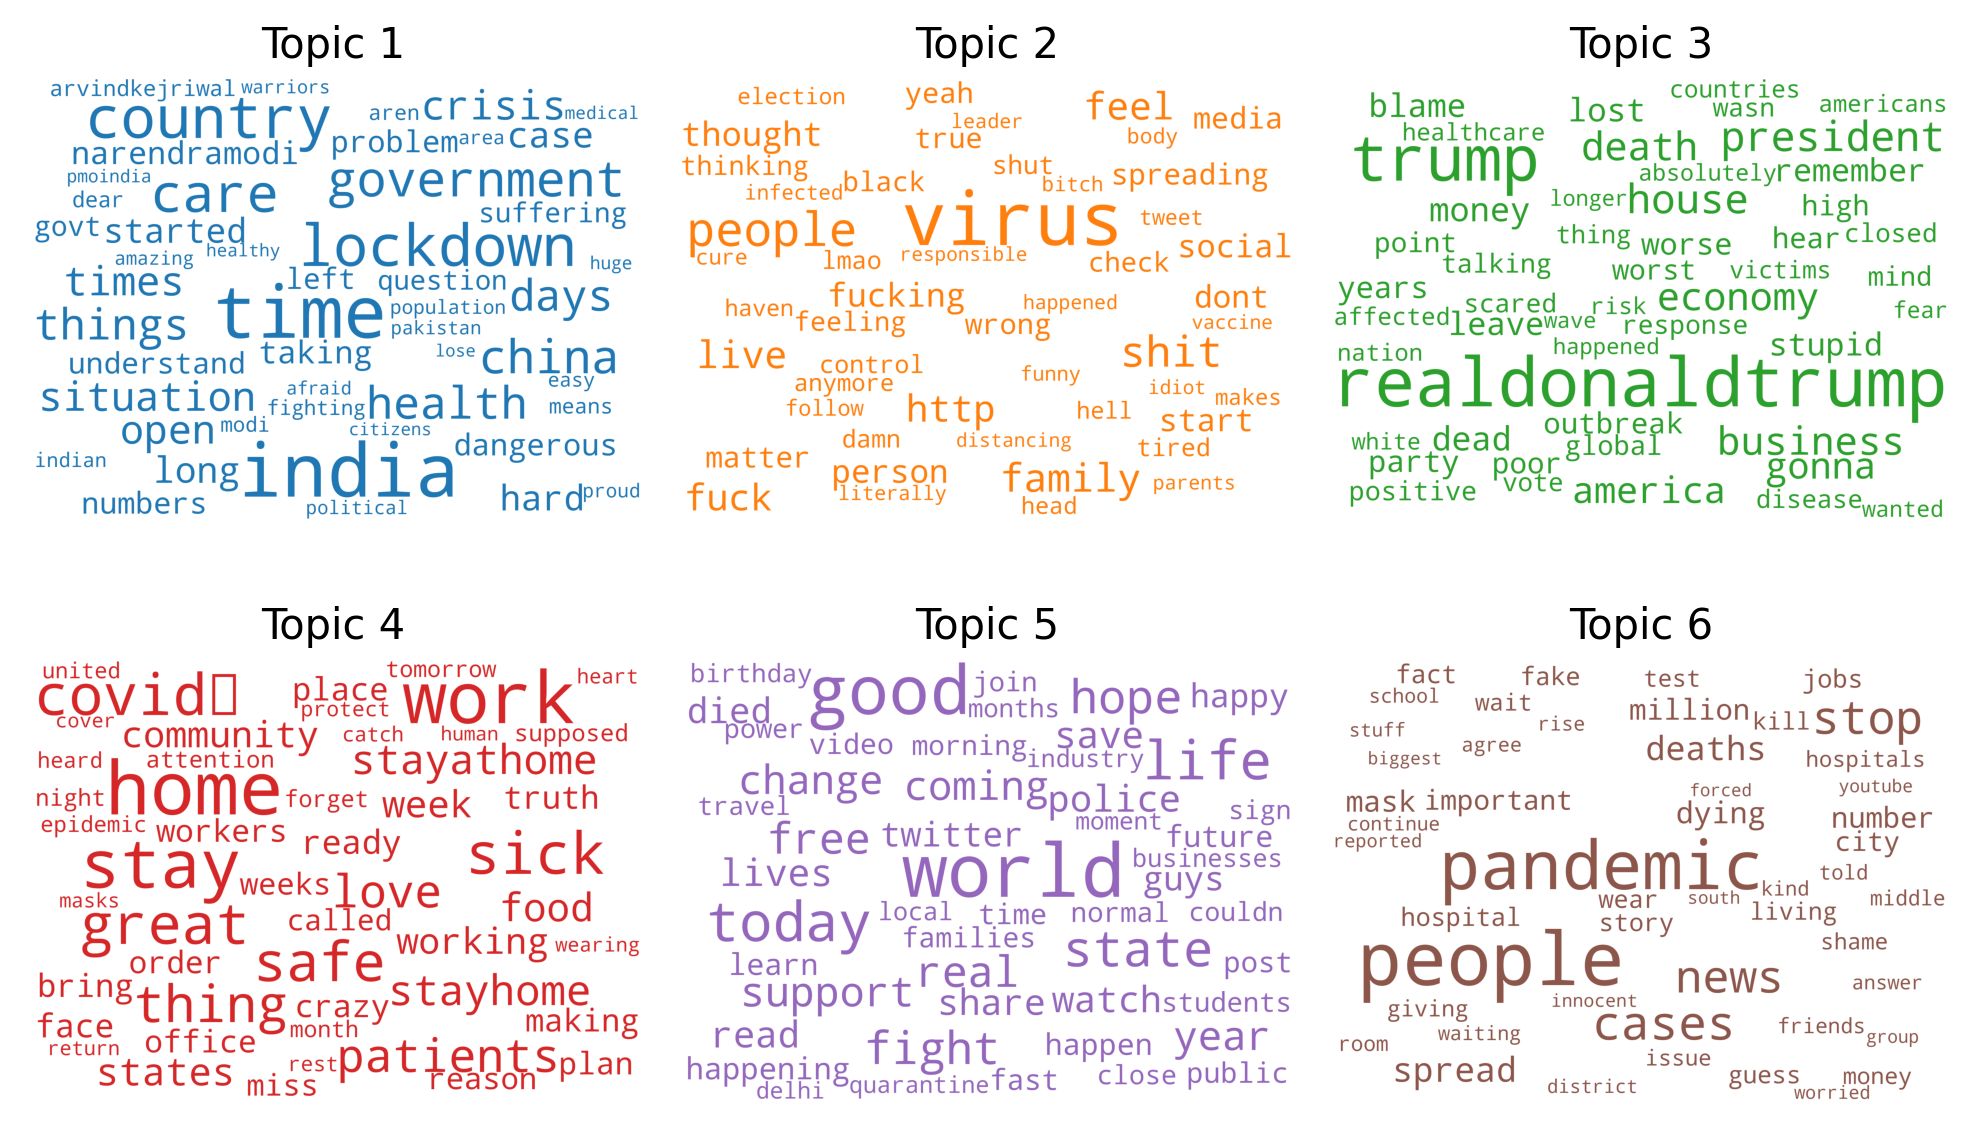

In [39]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model_6.show_topics(num_topics=6, num_words=50, formatted=False)
fig, axes = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True, dpi=250)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

The 6 topics above already indicate some meaningful results. If you run the code with our models, you will see the same clouds here. If you have created your own models, the order and exact words in the clouds might be different. In our case, we can see the following topics:

 - Topic 1: **Lockdown, Countries** 
 - Topic 2: **Virus, Cursing** 
 - Topic 3: **American politics** 
 - Topic 4: **Social Compassion** 
 - Topic 5: **General Concepts**
 - Topic 6: **Pandemic Reports**
 
Of course, our interpretation is in itself a topic clustering as we are looking at selected words from those topics. We basically infere a topic ourselves, this is fine because we only look at 6 topics even though there might be many more topics within those. We should therefore be careful not to stop our observation here or call those 6 topics definite. 

## Visualization II: pyLDAvis
In order to investigate the correlations between our topics even further, we can also use another visualization tool. Where wordcloud was rather intuitive to understand (word frequencies are mapped on size of words in clouds), we can look at pyLDAvis, which is a bit more complex but also a lot more informative. You can learn more about the [algorthms behind LDAvis in their paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf). You can look at the code for the package in their [git repository](https://github.com/bmabey/pyLDAvis). The next cell installs the model followed by one that uses pyLDAvis to create the visualization, but **careful** as this is rather computationally expensive and might take a lot of time. As you do not want to run this more than once, we are saving the result in an html file.

In [31]:
!pip install pyLDAvis

In [40]:
import pyLDAvis.gensim

print("Building visualization.")
p = pyLDAvis.gensim.prepare(model_16, bow_corpus, dictionary, mds='mmds', sort_topics=False)
pyLDAvis.save_html(p, 'lda_16.html')

print("Building visualization.")
p = pyLDAvis.gensim.prepare(model_24, bow_corpus, dictionary, mds='mmds', sort_topics=False)
pyLDAvis.save_html(p, 'lda_24.html')

Building visualization.


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


Building visualization.


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [33]:
HTML(filename='lda_16.html')

In [34]:
HTML(filename='lda_24.html')

## Infering topic for new data
In the above visualization we can identify the distributions of words within the topics more graphically. Sliding over individual terms on the right side of the graph, we can also see to what extent each word can be found in each topic. This is a good starting point for any further analysis of terms. Let say we want to investigate which of these topics can be linked to sinophiobia for example. Here, we can now make use of the LDA model. The model can provide a statistical inference for new terms and can return a probability for each word to belong to a topic. To do this, we also need the dictionary from our original corpus.
In the next cell, we will have a look at an example. We would assume that the words Trump, USA, Potus, America, American President would appear in at least one of our topics, when we look at the words in the word cloud or the distribution in the visualisation. Let us check this intuition by probing our model with the list of words.

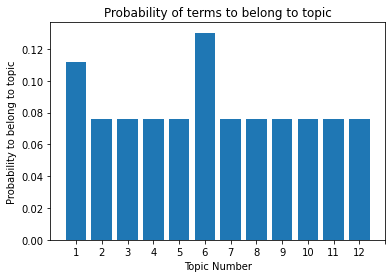

In [35]:
# Create a new corpus, made of previously unseen terms. Has to be a list of lists.
other_texts = [['trump','usa','potus','america','president','american']]

# Turn our list of terms into a "corpus" with the doc2bow function
other_corpus = [dictionary.doc2bow(text) for text in other_texts]
unseen_doc = other_corpus[0]
vector = model_12[unseen_doc]  # get topic probability distribution for a document

# Visualize the resulting vector
x = [vec[0] for vec in vector]
y = [vec[1] for vec in vector]

plt.bar(x,y)
plt.ylabel("Probability to belong to topic")
plt.xticks(range(0,13),range(1,13))
plt.xlabel("Topic Number")
plt.title("Probability of terms to belong to topic")
plt.show()

# Sentiment Analysis

Our next observation concerns the sentiment of the corpus. Ideally, we combine this approach with the results we have so far. Why don't we investigate the sentiment for each of our 12 topics? Maybe we can identify which topics are more negative/positive or objective/subjective?

For this analysis of sentiment we will use the [**TextBlob**](https://textblob.readthedocs.io/en/dev/) library for simplified language processing. There is a variety of different sentiment classifiers out there. 

For more information on TextBlob: *Loria, Steven, et al. "Textblob: simplified text processing." Secondary TextBlob: simplified text processing 3 (2014).* 

TextBlob's sentiment analysis is based on a separate library called pattern. The sentiment analysis lexicon bundled in Pattern focuses on adjectives and contains adjectives that occur frequently in customer reviews, hand-tagged with values for polarity and subjectivity (see: *De Smedt, Tom, and Walter Daelemans. "Pattern for python." The Journal of Machine Learning Research 13.1 (2012): 2063-2067.*) 

## Topic Sentiment

For now, let us investigate how the 12 topics relate with respect to sentiment dimensions. Textblob allows us to retrieve a polarity (positive, negative) and subjectivity (opinion, fact) score for each tweet. We can now use our model to tag each tweet with the topic it is most likely to fall into. For this we do the following:


1.   Get a list of the 5 most important words of each topic
2.   Check which tweet falls into which topic by checking for those words
3.   Check the sentiment for each tweet of those topics






In [108]:
# Get a list of the 5 most important words of each topic

from pprint import pprint
topic_words = dict()

for index, words in enumerate(model_12.print_topics(num_words=5)):
  words = words[1].split(" + ")
  words = [word.split("*")[1].replace("\"","") for word in words]
  topic_words[index] = words

pprint(topic_words)

{0: ['realdonaldtrump', 'pandemic', 'shit', 'america', 'worse'],
 1: ['pandemic', 'family', 'live', 'hope', 'house'],
 2: ['people', 'work', 'country', 'care', 'health'],
 3: ['news', 'thing', 'great', 'days', 'stayhome'],
 4: ['india', 'state', 'patients', 'crisis', 'read'],
 5: ['trump', 'people', 'president', 'business', 'wrong'],
 6: ['virus', 'stop', 'things', 'love', 'spreading'],
 7: ['today', 'government', 'feel', 'person', 'true'],
 8: ['home', 'stay', 'sick', 'covidー', 'safe'],
 9: ['world', 'good', 'life', 'fight', 'real'],
 10: ['cases', 'http', 'spread', 'deaths', 'social'],
 11: ['time', 'lockdown', 'free', 'situation', 'fuck']}


In [145]:
# Check which tweet falls into which topic by checking for those words

topic_tweets = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}

for tweet in tweet_token_docs:
  counts = []
  for topic_num, word_list in topic_words.items():
    counts.append(len(set(tweet).intersection(set(word_list))))
  
  max_item = max(counts)
  if max_item > 0:
    topic_tweets[counts.index(max_item)].append(tweet)
  else:
    topic_tweets[12].append(tweet)
    
total_tweet_num = 0
for topic_num, tweets in topic_tweets.items():
  if topic_num == 12:
    print("---")
  else:
    total_tweet_num += len(tweets)
  print(topic_num, len(tweets))

print("\nTotal tweets with topic: ", total_tweet_num)

0 1217
1 782
2 2236
3 844
4 511
5 355
6 1274
7 582
8 744
9 857
10 474
11 694
---
12 15179

Total tweets with topic:  10570


We can now see that not all tweets can be identified by only the 5 most important keywords. But for now, we only want to consider those tweets which can be identified by those most important keywords. Now, we can take those tweets and evaluate the average sentiment for the topic. Let's draw a sample from each topical tweet and evaluate the sentiment.

In [152]:
from textblob import TextBlob
import numpy as np
import random

sample_size = 300

topic_polarity = dict()
topic_subjectivity = dict()

for topic_num, tweets in topic_tweets.items():
  print("Evaluating", sample_size, "topic-tweets: ", topic_num)

  polarity = 0
  subjectivity = 0
  for tweet in random.sample(tweets, sample_size): 
    blob = TextBlob(" ".join(tweet))
    polarity += blob.sentiment.polarity
    subjectivity += blob.sentiment.subjectivity
    
  topic_polarity[topic_num] = polarity/sample_size
  topic_subjectivity[topic_num] = subjectivity/sample_size

Evaluating 300 topic-tweets:  0
Evaluating 300 topic-tweets:  1
Evaluating 300 topic-tweets:  2
Evaluating 300 topic-tweets:  3
Evaluating 300 topic-tweets:  4
Evaluating 300 topic-tweets:  5
Evaluating 300 topic-tweets:  6
Evaluating 300 topic-tweets:  7
Evaluating 300 topic-tweets:  8
Evaluating 300 topic-tweets:  9
Evaluating 300 topic-tweets:  10
Evaluating 300 topic-tweets:  11
Evaluating 300 topic-tweets:  12


In [157]:
print("Polarity: ")
pprint(topic_polarity)
print("\nSubjectivity: ")
pprint(topic_subjectivity)

Polarity: 
{0: -0.041342329044412394,
 1: 0.07753599376703543,
 2: 0.0378802999488937,
 3: 0.229507582521645,
 4: 0.036817018448372624,
 5: -0.120781197515833,
 6: 0.03615913507788508,
 7: 0.06986516474266478,
 8: 0.03577551366843032,
 9: 0.17046839456068633,
 10: 0.06726340187590187,
 11: 0.025760752543862658,
 12: 0.02837597402597403}

Subjectivity: 
{0: 0.45451830206830207,
 1: 0.40120037538079223,
 2: 0.415767364518198,
 3: 0.5000044793169792,
 4: 0.3290181412414745,
 5: 0.5443701308722145,
 6: 0.3578083826667161,
 7: 0.4137108525733526,
 8: 0.4687421115921116,
 9: 0.3983768133718129,
 10: 0.33778418510501834,
 11: 0.39909135143956537,
 12: 0.23408783068783065}


We have now evaluated the polarity and the subjectivity for a sample of 300 tweets from each set of tweets related to one of the 12 topics. Let's visualize our results!

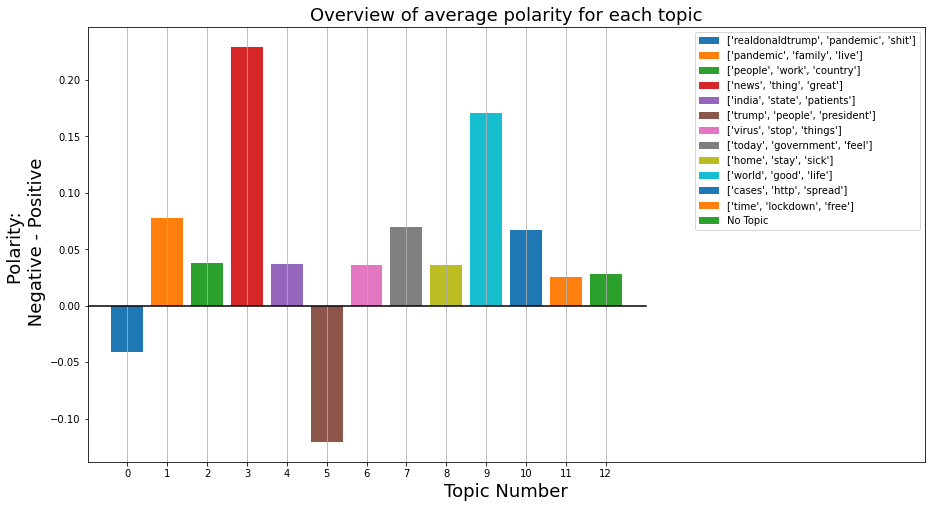

In [219]:
plt.figure(figsize=[15,8])
plt.plot(range(-1,14),np.zeros(15),"black")

for key, value in topic_polarity.items():
  if key < 12:
    plt.bar(key, value, label=list(topic_words[key])[:3])
  else:
    plt.bar(key, value, label="No Topic")
    
plt.title("Overview of average polarity for each topic", fontsize=18)
plt.xlabel("Topic Number", fontsize=18)
plt.ylabel("Polarity: \n Negative - Positive", fontsize=18)
plt.xlim([-1,20])
plt.grid(axis="x")
plt.xticks(range(0,13))
plt.legend()


These are some pretty interesting insights! We can observe two topics to be mostly negative. **Topic 0** and **Topic 5**. We've also plotted the top 3 most important words from each topic on the left of the plot. This should help is interpret the result. We can see that **Topic 0** features terms about the president, the pandemic and "shit". This could relate to tweets about Trump talking shit about the pandemic - arguable a negative topic. Furthermore, **Topic 5** is even more negative. Topics here are also Trump, people and the President. Looks like our model suggests that the talks about the American president and the pandemic are rather negative. On the other hand, **Topics 3** and **9** seem to be mostly positive with talks about news, great, world, good, life. Now, we can also look at the objectivity of those topics. Maybe we can identify some interesting correlations.

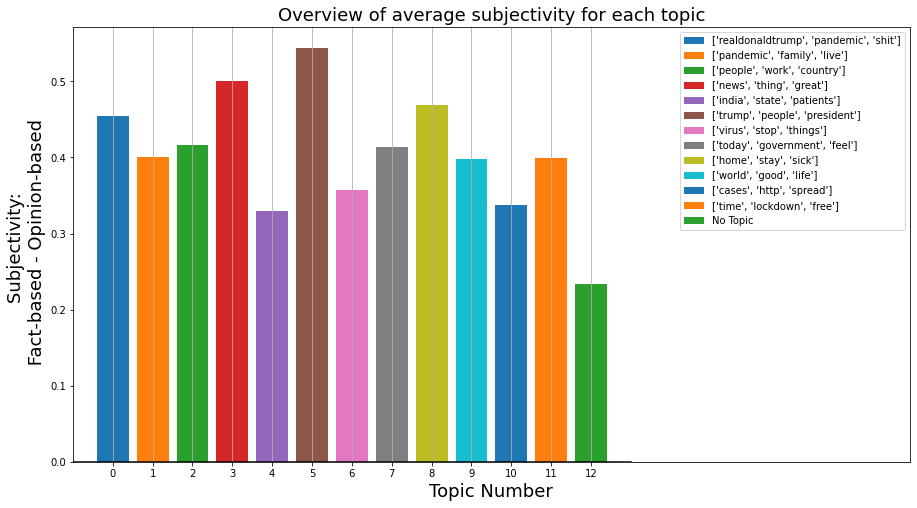

In [220]:
plt.figure(figsize=[15,8])
plt.plot(range(-1,14),np.zeros(15),"black")

for key, value in topic_subjectivity.items():
  if key < 12:
    plt.bar(key, value, label=list(topic_words[key])[:3])
  else:
    plt.bar(key, value, label="No Topic")
    
plt.title("Overview of average subjectivity for each topic", fontsize=18)
plt.xlabel("Topic Number", fontsize=18)
plt.ylabel("Subjectivity: \n Fact-based - Opinion-based", fontsize=18)
plt.xlim([-1,20])
plt.grid(axis="x")
plt.xticks(range(0,13))
plt.legend()


Finally, we can now see that the most subjective topics are **3** and **5**. Arguably, these are the most positive and negative topics as well, which makes sense since highly polarized tweets are probably more subjective.

Next, we could look at tweets on an individual basis and try to disect these phenomena. But at some point we have to stop, since we are really just dealing with a fictional dataset and might end up "discovering" things that are not really there.

# Conclusion

![alt text](https://media1.tenor.com/images/5a7baa3abccc024569143229fa700dd6/tenor.gif?itemid=10592594)

We have now explored a variety of tools using different NLP libraries. Starting with basic processing and analysis, we've used the LDA topic modeling from the Gensim library with some advanced parameters to generate a couple of topic models. Then, we have used the TextBlob library to perform some sentiment analysis and relate those findings with the topics we've identified.

Overall, this tutorial is just a glimpse of what you can achieve using a variety of NLP tools. But hopefully, you can now start to analyse your own corpus with these tools.

Happy coding.